In [1]:
#Import Necessary Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
#from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

c:\Users\Priya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Find Device type
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device being used is: {device}")

The device being used is: cpu


In [3]:
#Load the Data
Train_data = 'C:/Users/Priya/OneDrive/Desktop/Emotion Detection/train'
Test_data = 'C:/Users/Priya/OneDrive/Desktop/Emotion Detection/test'

In [4]:
#Data Transformations
transform = transforms.Compose([
    transforms.Grayscale(), 
    transforms.Resize((48, 48)),  
    transforms.ToTensor(), 
])

In [5]:
#Load Datasets
train_dataset = datasets.ImageFolder(root=Train_data, transform=transform)
test_dataset = datasets.ImageFolder(root=Test_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
#Defining the CNN Model
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 12 * 12, 256)  
        self.fc2 = nn.Linear(256, len(train_dataset.classes))  

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)  
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
#Training Setup
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [8]:
#Training the Model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Loss: 1.6349
Epoch [2/10], Loss: 1.4417
Epoch [3/10], Loss: 1.3303
Epoch [4/10], Loss: 1.2396
Epoch [5/10], Loss: 1.1491
Epoch [6/10], Loss: 1.0639
Epoch [7/10], Loss: 0.9726
Epoch [8/10], Loss: 0.8792
Epoch [9/10], Loss: 0.7835
Epoch [10/10], Loss: 0.6841


In [9]:
# Save the model
torch.save(model.state_dict(), 'cnn_emotion_model.pth')
#model.load_state_dict(torch.load('cnn_emotion_model.pth'))
#model.eval()

In [10]:
#Evaluate the Model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

all_labels, all_preds = evaluate_model(model, test_loader)

In [11]:
#Generate Classification Report and Confusion Matrix
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes, zero_division=0)  
print(report)
# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

              precision    recall  f1-score   support

       angry       0.39      0.46      0.42       958
     disgust       0.55      0.45      0.50       111
        fear       0.37      0.39      0.38      1024
       happy       0.72      0.69      0.71      1774
     neutral       0.49      0.45      0.47      1233
         sad       0.38      0.35      0.37      1247
    surprise       0.65      0.69      0.67       831

    accuracy                           0.51      7178
   macro avg       0.51      0.50      0.50      7178
weighted avg       0.52      0.51      0.51      7178



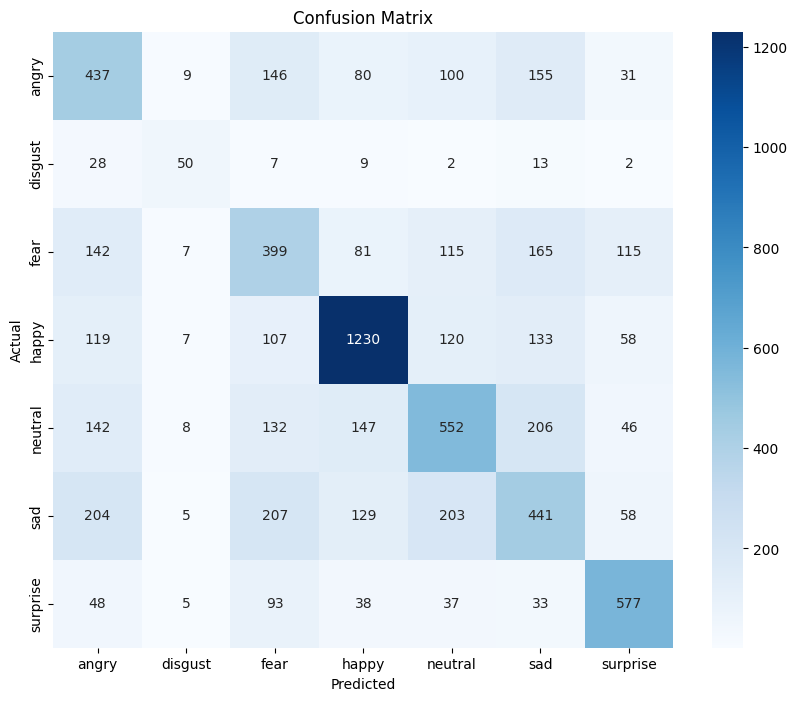

In [12]:
#Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()